In [1]:
# Cell 1: Import required libraries

import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Define KNearestNeighbor class
# - Extended from lecture code
# - Supports k > 1 neighbors with majority voting
# - Supports distance metric: 'l1' (Manhattan) or 'l2' (Euclidean)
# - Default metric is 'l2'

# Usage example:
#   knn = KNearestNeighbor(k=3, metric='l1')   # Manhattan distance
#   knn.train(X_train, y_train)
#   y_pred = knn.predict(X_test[:1000])
#
#   knn = KNearestNeighbor(k=5, metric='l2')   # Euclidean distance
#   knn.train(X_train, y_train)
#   y_pred = knn.predict(X_test[:1000])

class KNearestNeighbor:
    def __init__(self, k=1, metric='l2'):
        self.k = k
        self.metric = metric

    def train(self, X, y):
        self.Xtr = X
        self.ytr = y

    def compute_distance(self, x):
        if self.metric == 'l1':
            return np.sum(np.abs(self.Xtr - x), axis=1)
        elif self.metric == 'l2':
            return np.sum((self.Xtr - x) ** 2, axis=1)
        else:
            raise ValueError("Unsupported metric. Use 'l1' or 'l2'.")

    def predict(self, X):
        num_test = X.shape[0]
        Ypred = np.zeros(num_test, dtype=self.ytr.dtype)

        for i in range(num_test):
            distances = self.compute_distance(X[i])
            nearest_idxs = np.argsort(distances)[:self.k]
            nearest_labels = self.ytr[nearest_idxs]
            Ypred[i] = Counter(nearest_labels).most_common(1)[0][0]

        return Ypred


In [3]:
# Cell 3: Load and preprocess CIFAR-10 dataset
# - Flatten images to vectors of size (3072,)
# - Split into train and test arrays

transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)

X_train = trainset.data.reshape(len(trainset.data), -1)
y_train = np.array(trainset.targets)
X_test = testset.data.reshape(len(testset.data), -1)
y_test = np.array(testset.targets)

print("Train:", X_train.shape, "Test:", X_test.shape)

100%|██████████| 170M/170M [00:02<00:00, 63.9MB/s]


Train: (50000, 3072) Test: (10000, 3072)


In [4]:
# Cell 4: Train/Test split (Baseline)
# - Use full training set for training
# - Fix k=5 (a common default choice in KNN)
# - Evaluate on a subset of the test set
# - Report Accuracy, Precision, Recall, F1-score
# - Purpose: Provide a baseline performance
#   before tuning k with validation or CV

knn = KNearestNeighbor(k=5)
knn.train(X_train, y_train)
y_pred = knn.predict(X_test[:2000])  # subset for speed

print("== Train/Test Split (Baseline, k=5) ==")
print("Accuracy :", accuracy_score(y_test[:2000], y_pred))
print("Precision:", precision_score(y_test[:2000], y_pred, average="macro"))
print("Recall   :", recall_score(y_test[:2000], y_pred, average="macro"))
print("F1       :", f1_score(y_test[:2000], y_pred, average="macro"))


== Train/Test Split (Baseline, k=5) ==
Accuracy : 0.2435
Precision: 0.30254296396590263
Recall   : 0.24187452238784563
F1       : 0.22550695765777182


In [5]:
# Cell 5: Train/Validation/Test split
# - Split training set into train and validation
# - Try different k values to tune hyperparameter
# - Evaluate with Accuracy, Precision, Recall, F1 on validation set
# - Select best k (highest validation accuracy)
# - Purpose: Improve upon the baseline (Cell 4, fixed k=5)
#            by choosing the optimal k using validation

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

best_k, best_acc = None, 0
for k in [1, 3, 5, 7, 9]:
    knn = KNearestNeighbor(k=k)
    knn.train(X_train_sub, y_train_sub)
    val_pred = knn.predict(X_val[:1000])

    acc = accuracy_score(y_val[:1000], val_pred)
    prec = precision_score(y_val[:1000], val_pred, average="macro")
    rec = recall_score(y_val[:1000], val_pred, average="macro")
    f1 = f1_score(y_val[:1000], val_pred, average="macro")

    print(f"k={k}, Val -> Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    if acc > best_acc:
        best_k, best_acc = k, acc

print("Best k from validation:", best_k)


k=1, Val -> Acc=0.2410, Prec=0.2792, Rec=0.2514, F1=0.2291
k=3, Val -> Acc=0.2560, Prec=0.3028, Rec=0.2677, F1=0.2402
k=5, Val -> Acc=0.2400, Prec=0.2915, Rec=0.2527, F1=0.2183
k=7, Val -> Acc=0.2370, Prec=0.2850, Rec=0.2507, F1=0.2106
k=9, Val -> Acc=0.2310, Prec=0.2780, Rec=0.2451, F1=0.2039
Best k from validation: 3


In [6]:
# Cell 6: Final Test evaluation (best k)
# - Retrain with full training set using best k (from Cell 5 validation)
# - Evaluate on test set with Accuracy, Precision, Recall, F1
# - Purpose: Compare final tuned performance against baseline (Cell 4, k=5)
#            and confirm whether validation tuning improved results

knn = KNearestNeighbor(k=best_k)
knn.train(X_train, y_train)
y_pred = knn.predict(X_test[:2000])

print("== Final Test (best k) ==")
print("Accuracy :", accuracy_score(y_test[:2000], y_pred))
print("Precision:", precision_score(y_test[:2000], y_pred, average="macro"))
print("Recall   :", recall_score(y_test[:2000], y_pred, average="macro"))
print("F1       :", f1_score(y_test[:2000], y_pred, average="macro"))


== Final Test (best k) ==
Accuracy : 0.248
Precision: 0.29836394192561166
Recall   : 0.24632255818646062
F1       : 0.23809628291259538


In [9]:
# Cell 7: 5-Fold Cross Validation
# - Perform k-fold CV with k values [1, 3, 5, 7, 9]
# - Compute Accuracy, Precision, Recall, F1 for each fold
# - Report mean and std across folds
# - Purpose: Provide more reliable evaluation
#            compared to baseline (Cell 4, fixed k=5)
#            and validation split (Cell 5)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = [1, 3, 5, 7, 9]

acc_means, acc_stds = [], []
prec_means, rec_means, f1_means = [], [], []

for k in k_values:
    acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        knn = KNearestNeighbor(k=k)
        knn.train(X_tr, y_tr)
        val_pred = knn.predict(X_val[:500])  # subset for speed

        acc_scores.append(accuracy_score(y_val[:500], val_pred))
        prec_scores.append(precision_score(y_val[:500], val_pred, average="macro"))
        rec_scores.append(recall_score(y_val[:500], val_pred, average="macro"))
        f1_scores.append(f1_score(y_val[:500], val_pred, average="macro"))

    acc_means.append(np.mean(acc_scores))
    acc_stds.append(np.std(acc_scores))
    prec_means.append(np.mean(prec_scores))
    rec_means.append(np.mean(rec_scores))
    f1_means.append(np.mean(f1_scores))

    print(f"k={k}, CV -> Acc={np.mean(acc_scores):.4f}, Prec={np.mean(prec_scores):.4f}, Rec={np.mean(rec_scores):.4f}, F1={np.mean(f1_scores):.4f}")

k=1, CV -> Acc=0.2532, Prec=0.2940, Rec=0.2523, F1=0.2426
k=3, CV -> Acc=0.2636, Prec=0.3078, Rec=0.2627, F1=0.2497
k=5, CV -> Acc=0.2612, Prec=0.3192, Rec=0.2596, F1=0.2424
k=7, CV -> Acc=0.2536, Prec=0.3184, Rec=0.2532, F1=0.2340
k=9, CV -> Acc=0.2504, Prec=0.3225, Rec=0.2501, F1=0.2305


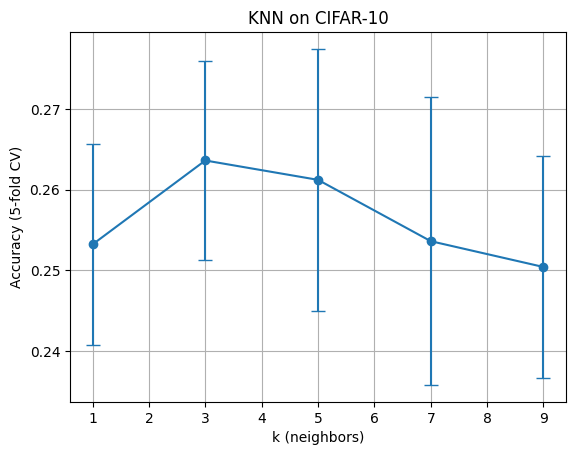

In [10]:
plt.errorbar(k_values, acc_means, yerr=acc_stds, fmt='-o', capsize=5)
plt.xlabel("k (neighbors)")
plt.ylabel("Accuracy (5-fold CV)")
plt.title("KNN on CIFAR-10")
plt.grid(True)
plt.show()